In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [60]:
kuaizi.set_env(project='popsed', name='', data_dir='/Users/jiaxuanli/Dropbox (Princeton)/Data')

'/Users/jiaxuanli/Dropbox (Princeton)/Data/popsed/'

In [61]:
import fsps
import sedpy
from sedpy.observate import load_filters
import prospect
from prospect.sources.constants import cosmo
import exspect
import sys
sys.path.append('/Users/jiaxuanli/Dropbox (Princeton)/Research/popsed/')

In [248]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [63]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

### Let's think about the prior distributions for sampling traning SEDs

$\log\, M_\star\ [M_\odot] \sim \rm Uniform[9.0, 12.0, 0.1]$ (fast)

$t_{\rm age}\ [\rm Gyr] \sim \rm Uniform[0.5, t_{univ}(z), 0.4]$ (fast)

$\log\, \tau\ [\rm Gyr] \sim \rm Uniform[-2, 2, 0.2]$ (slow)

$z=0.05$ (we can try $z \sim \rm \mathcal{N}(0.1, 0.05^2)$ in the future)

In [251]:
import itertools

In [255]:
zred_set = np.array([0.05])
mass_set = 10**(np.linspace(9, 12, 10))
tage_set = np.linspace(1, float(cosmo.age(zred_set[0]).value), 10)
tau_set = 10**(np.arange(-2, 2, 0.4))

In [256]:
# Sample the stellar mass -- SFR plane
sfr_li = []
mass_li = []
mwa_li = []
tau_li = []
tage_li = []

for zred, mass, tage, tau in itertools.product(zred_set, mass_set, tage_set, tau_set):
    #print(np.log10(mass), tage, tau)
    model = mock.build_model(mass=mass, zred=zred, 
                             tage=tage, tau=tau, 
                             sfh=1, add_dustabs=False,
                             uniform_priors=True)
    sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, t_avg = 50 Myr
    sfr_li.append(float(sfr))
    mass_li.append(mass)
    mwa_li.append(parametric_mwa(tau=tau, tage=cosmo.age(zred).value, power=0)) # power=0 for tau-model
    tau_li.append(tau)
    tage_li.append(tage)

Text(0, 0.5, '$\\log\\ \\mathrm{SFR}\\ [M_\\odot\\ \\rm{yr}^{-1}]$')

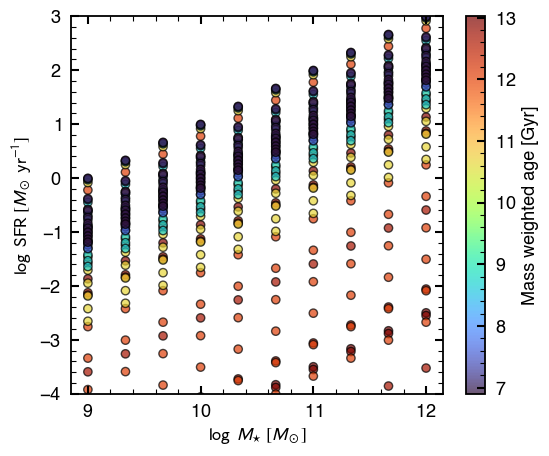

In [257]:
plt.scatter(np.log10(mass_li), np.log10(sfr_li), c=mwa_li, alpha=0.7)
plt.colorbar(label='Mass weighted age [Gyr]')
plt.ylim(-4, 3)

plt.xlabel(r'$\log\ M_{\star}\ [M_\odot]$')
plt.ylabel(r'$\log\ \mathrm{SFR}\ [M_\odot\ \rm{yr}^{-1}]$')

#### Looks not bad? Try to generate some SEDs and benchmark the speed

In [75]:
sps = mock.build_sps(add_realism=False)

In [327]:
obs_set = []

In [328]:
%%time
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
for zred, mass, tage, tau in itertools.product(zred_set, mass_set, tage_set, tau_set):
    model = mock.build_model(mass=mass, zred=zred, 
                             tage=tage, tau=tau, 
                             sfh=1, add_dustabs=False,
                             uniform_priors=True)
    sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, t_avg = 50 Myr
    model.params['sfr'] = sfr
    obs = mock.build_obs(sps, model, 
                         snr_spec=20, snr_phot=20, 
                         filterset=sdss, 
                         continuum_optimize=False)
    obs_set.append(obs)

CPU times: user 13.9 s, sys: 815 ms, total: 14.7 s
Wall time: 14.7 s


In [329]:
len(obs_set)

1000

In [330]:
with open('train_sed_1000.pkl', 'wb') as f:
    pickle.dump(obs_set, f)
    f.close()

In [275]:
# model = mock.build_model(mass=5e10, logzsol=-0.5, zred=0.05, 
#                          tage=0.1, tau=2.5, 
#                          sfh=1, add_dustabs=False,
#                          continuum_optimize=True,
#                          mask_elines=False,
#                          uniform_priors=True)
# sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, avg = 50 Myr
# print(sfr)
# model.params['sfr'] = sfr
# model.params['ssfr'] = model.params['sfr'] / model.params['mass']
# obs1 = mock.build_obs(sps, model, 
#                       snr_spec=20, snr_phot=20, 
#                       filterset=sdss, 
#                       continuum_optimize=False)

No handles with labels found to put in legend.


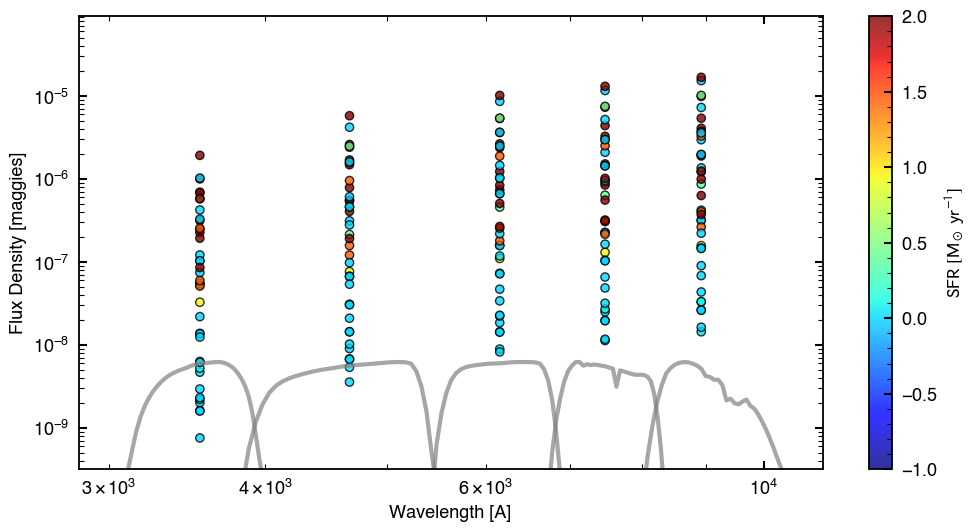

In [331]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(12, 6))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, ob['maggies'],
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=1, vmax=10,
#          c=np.ones_like(wphot) * ob['mock_params']['tau'], cmap='jet')
    sct = plt.scatter(wphot, ob['maggies'],
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-1, vmax=2,
         c=np.ones_like(wphot) * sfr, cmap='jet')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin / 10, ymax * 1000])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

(25.0, 9.0)

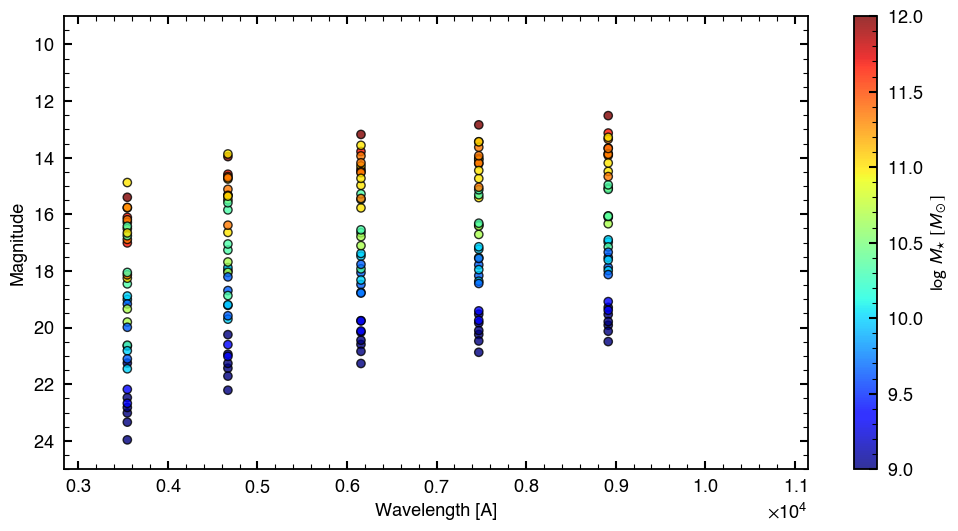

In [334]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax =  -2.5 * np.log10(obs["maggies"].min())*0.8, -2.5 * np.log10(obs["maggies"].max())/0.4
plt.figure(figsize=(12, 6))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=9, vmax=12,
         c=np.ones_like(wphot) * np.log10(ob['mock_params']['mass']), cmap='jet')
#     sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=-3, vmax=2,
#          c=np.ones_like(wphot) * np.log10(sfr), cmap='jet_r')
    
plt.colorbar(sct, label=r'$\log\, M_{\star}\ [M_\odot]$')
    
# # plot Filters
# for f in obs['filters']:
#     w, t = f.wavelength.copy(), f.transmission.copy()
#     t = t / t.max()
#     t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
#     plt.plot(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])
#plt.xscale("log")
#plt.yscale("log")
#plt.legend(loc='best')

(25.0, 9.0)

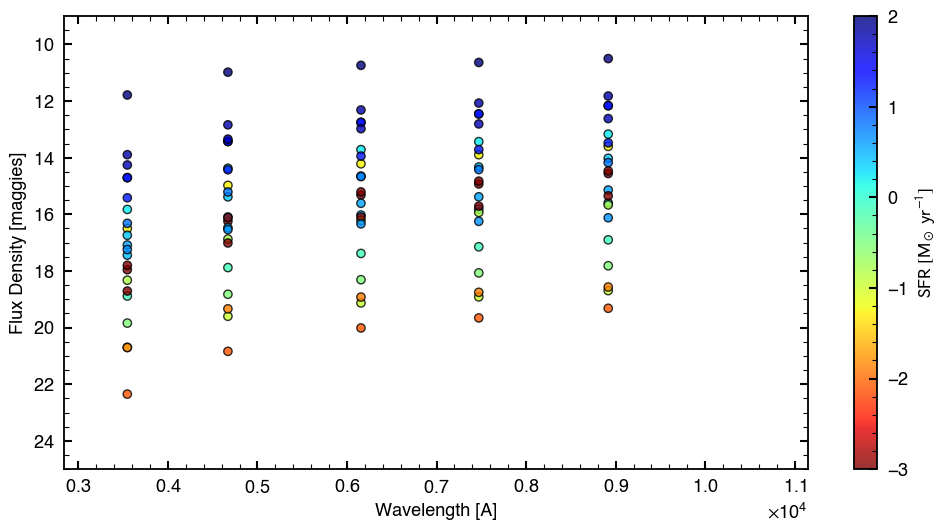

In [333]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax =  -2.5 * np.log10(obs["maggies"].min())*0.8, -2.5 * np.log10(obs["maggies"].max())/0.4
plt.figure(figsize=(12, 6))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=9, vmax=12,
#          c=np.ones_like(wphot) * np.log10(ob['mock_params']['mass']), cmap='jet')
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-3, vmax=2,
         c=np.ones_like(wphot) * np.log10(sfr), cmap='jet_r')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# # plot Filters
# for f in obs['filters']:
#     w, t = f.wavelength.copy(), f.transmission.copy()
#     t = t / t.max()
#     t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
#     plt.plot(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])
#plt.xscale("log")
#plt.yscale("log")
#plt.legend(loc='best')

In [232]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)